In [6]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from astropy.io import fits
import numpy as np
from PIL import Image

import os

import torch
import torch.nn as nn
from torch.functional import F

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.io import read_image
from torchvision import models

from src.get_data import gen_dataset
from src.auxiliar import plot_fits
from src.log import control

control.debug_mode = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
gen_dataset("""
            SELECT 
            TOP 5000
            det.id, det.ra, det.dec, det.field, det.B, det.A, det.flux_radius_50, det.theta, det.fwhm,
            
            r.r_auto
            FROM "idr4_dual"."idr4_detection_image" AS det 
            
            LEFT OUTER JOIN "idr4_dual"."idr4_dual_r" AS r ON r.id = det.id
            
            WHERE 1 = CONTAINS( POINT('ICRS', det.ra, det.dec), 
                    CIRCLE('ICRS', 0.5, 0.4, 1) ) 
                    AND r.r_auto < 17
    """,
    fits_folder="data/",
    arrays_folder="arrays/"
)

10/03/2024 15:25:04  [info] - get_data.py - gen_dataset() - Insert splus.cloud credentials
10/03/2024 15:25:09  [info] - get_data.py - gen_dataset() - Querying data
10/03/2024 15:25:26  [info] - get_data.py - gen_dataset() - Downloading stamps
10/03/2024 15:44:34  [info] - get_data.py - gen_dataset() - Finished generating dataset.


In [44]:
class AstroDataset(Dataset):
    def __init__(self, csv_file, images_dir, arrays_dir):
        self.df = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.arrays_dir = arrays_dir

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.df.iloc[idx, 0] + '.fits.fz')
        array_name = os.path.join(self.arrays_dir, self.df.iloc[idx, 0] + '.npy')
        image_data = np.load(array_name, allow_pickle=True)

        # Assuming image_data is 2D, add a channel dimension and convert to float
        image_data = torch.tensor(image_data, dtype=torch.float).unsqueeze(0)
        
        idx_col = self.df.columns.get_loc("r_auto")
        
        label = self.df.iloc[idx, idx_col]  # Assuming the label is in the second column
        label = torch.tensor([label], dtype=torch.float)

        return image_data, label

    def __len__(self):
        return len(self.df)
    

In [45]:
astro_dataset = AstroDataset(csv_file='data.csv', images_dir='data/', arrays_dir='arrays/')

train_size = int(0.8 * len(astro_dataset))
val_size = len(astro_dataset) - train_size

train_dataset, val_dataset = random_split(astro_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=48, shuffle=True)

C:\Users\gusta\AppData\Local\Temp\ipykernel_11492\1687448901.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


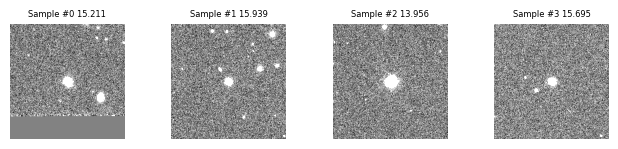

In [46]:
import matplotlib.pyplot as plt
fig = plt.figure()

for i, sample in enumerate(astro_dataset):
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'Sample #{i} {round(sample[1].item(), 3)}', {'fontsize': 6})
    ax.axis('off')
    plot_fits(sample[0][0], ax = ax)

    if i == 3:
        plt.show()
        break

In [76]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=1):
        super().__init__()
        
        # Load a pre-trained ResNet model
        self.resnet = models.resnet18()
        
        # Adjust the first convolutional layer
        # Original first conv layer for ResNet18: 3 input channels, 64 output channels, kernel size 7
        # Change to 1 input channel since your images are black and white
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Remove the fully connected layer (or modify accordingly)
        # Keeping the AdaptiveAvgPool2d layer from ResNet
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2], nn.AdaptiveAvgPool2d((1, 1)))
        
        # Define new fully connected layers for classification
        self.conv1 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)
            
    def forward(self, x):
        # Pass input through ResNet layers
        x = self.resnet(x)
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        # Flatten the output for the fully connected layer
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [77]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = ConvNet().to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [78]:

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        
        loss = criterion(outputs, labels)  # Squeeze outputs to match label dimensions
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

RuntimeError: mat1 and mat2 shapes cannot be multiplied (48x32 and 512x256)

In [53]:
def evaluate_model_regression(model, data_loader, criterion, device):
    """
    Evaluate the model on the given data loader (e.g., validation set) for regression tasks.

    Args:
        model: The trained model to evaluate.
        data_loader: DataLoader for the dataset to evaluate against.
        criterion: Loss function used for evaluation. Typically, nn.MSELoss for regression.
        device: The device (CPU or CUDA) the model and data should be on.

    Returns:
        average_loss: The average loss (e.g., MSE) over the data_loader.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_samples = 0
    
    with torch.no_grad():  # Inference mode, gradients not needed
        for data in data_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            
            loss = criterion(outputs.squeeze(), labels)
            total_loss += loss.item()
            total_samples += labels.size(0)
    
    average_loss = total_loss / len(data_loader)
    
    print(f'Validation Loss: {average_loss:.3f}')
    
    return average_loss

In [54]:
evaluate_model_regression(net, val_loader, criterion, device)

Validation Loss: 3.119


3.1189933750364514

In [57]:
test_val = iter(val_loader).__next__()

In [62]:
net(test_val[0].to(device))

tensor([[15.3856],
        [15.8336],
        [15.8101],
        [15.8185],
        [15.8305],
        [15.8009],
        [15.8216],
        [15.8305],
        [15.8439],
        [15.8269],
        [16.1650],
        [15.8773],
        [15.8124],
        [15.7607],
        [15.8142],
        [15.8567],
        [15.8259],
        [15.8026],
        [15.6708],
        [15.8476],
        [15.8055],
        [15.8093],
        [15.8283],
        [15.9931],
        [15.8014],
        [15.7368],
        [15.8299],
        [15.8448],
        [15.8393],
        [15.6425],
        [15.7851],
        [15.8047],
        [16.0535],
        [15.8553],
        [15.9217],
        [15.8287],
        [15.8066],
        [15.8156],
        [15.8257],
        [15.8282],
        [15.8228],
        [15.7982],
        [15.9896],
        [15.7925],
        [15.9362],
        [15.7528],
        [15.6287],
        [15.8171]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [63]:
test_val[1]

tensor([[16.7187],
        [14.3996],
        [16.5264],
        [13.9209],
        [15.2905],
        [15.3986],
        [15.8063],
        [15.3014],
        [14.5896],
        [14.9735],
        [15.1452],
        [16.6403],
        [12.6829],
        [11.7765],
        [16.0527],
        [14.8016],
        [15.8468],
        [16.8033],
        [12.6215],
        [15.1088],
        [14.4770],
        [16.7900],
        [15.2522],
        [16.4454],
        [16.8926],
        [12.2848],
        [15.3656],
        [14.5665],
        [15.7940],
        [13.5418],
        [15.3312],
        [16.2318],
        [16.6743],
        [16.2688],
        [15.2550],
        [16.9508],
        [16.3305],
        [16.7587],
        [15.1347],
        [15.0578],
        [15.5011],
        [15.9939],
        [15.9350],
        [13.8190],
        [12.8424],
        [13.0339],
        [11.5188],
        [15.9849]])